### 주식 차트를 통한 시계열 예측
---
- 시계열 데이터에 대한 수학적 설명
    - [시계열의 3가지 요건](http://www.dodomira.com/2016/04/21/arima_in_r/)
    - [공분산(Covariance)과 상관계수(Correlation)](https://destrudo.tistory.com/15)
    - [Autocovariance & Autocorrelation Function](https://m.blog.naver.com/sw4r/221030974616)
      

### 시계열 데이터 사례분석
- mkdir -p ~/aiffel/stock_prediction/data
- wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
- wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
- mv daily-min-temperatures.csv airline-passengers.csv ~/aiffel/stock_prediction/data

### 1. 시계열(Time Series) 생성

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
print('슝=3')

슝=3


In [2]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
# 이번에는 Date를 index_col로 지정하여 바꿈
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [5]:
# DataFrame인 df와 Series인 df['Temp']는 index 구조가 동일하여 호환가능함
ts1 = df['Temp']
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

### 2. 시계열 안정성의 정성적 분석

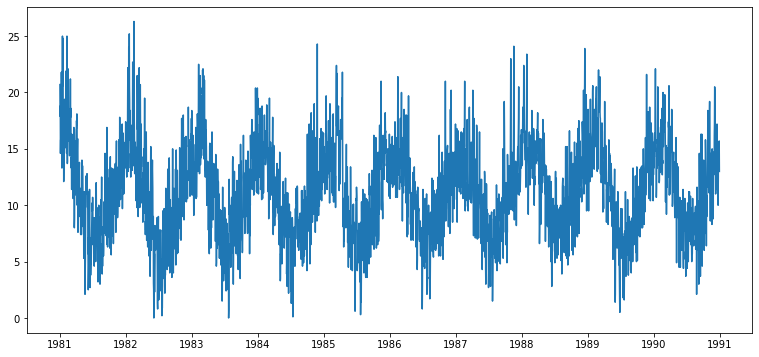

In [53]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 크기를 13, 6으로 지정

# 시계열(time series) 데이터를 차트화
plt.plot(ts1)

In [8]:
# 결측치 확인, 없음
ts1[ts1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Temp, dtype: float64)

#### 중간 정리
- 결측치는 제거나 보간하는 방법을 선택할 수 있는데 그 방법에 대한 링크
- [결측치 처리방법](https://rfriend.tistory.com/264)

Series([], Name: Temp, dtype: float64)


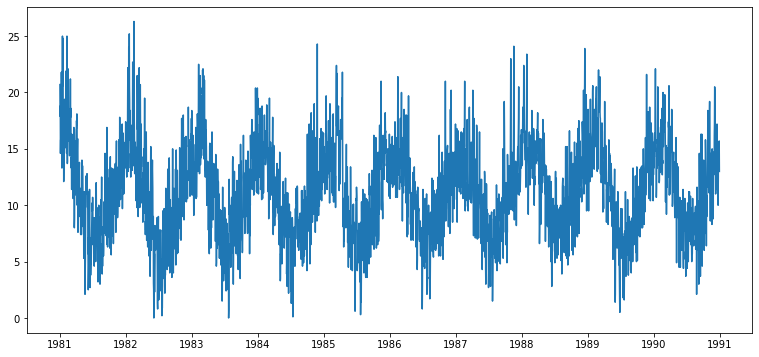

In [9]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts1=ts1.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts1[ts1.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts1)

In [10]:
# 구간 통계치를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


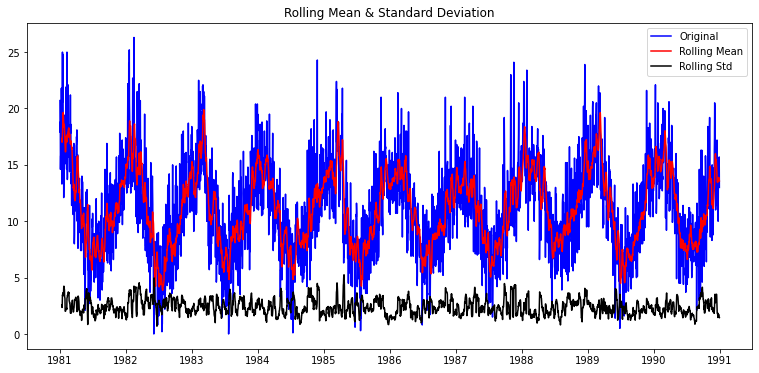

In [11]:
plot_rolling_statistics(ts1, window=12)

### 3. 다른 데이터와의 비교

In [12]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


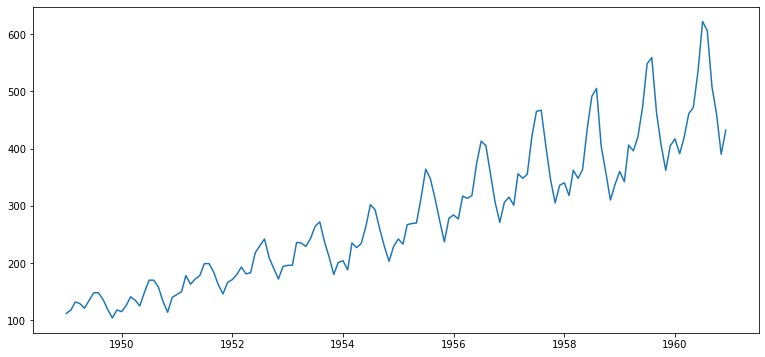

In [13]:
ts2 = df['Passengers']
plt.plot(ts2)

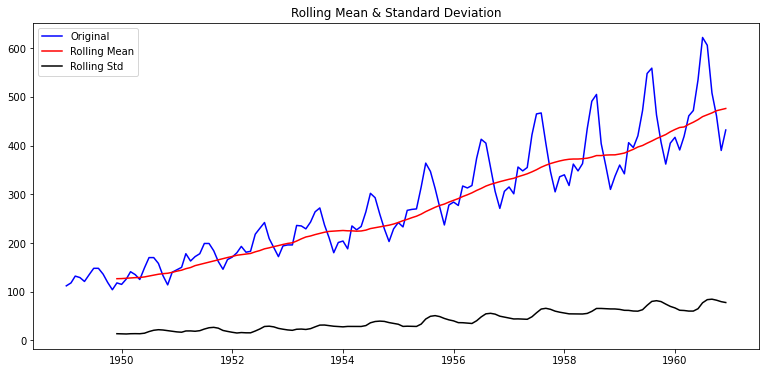

In [14]:
plot_rolling_statistics(ts2, window=12)

#### 시간의 추이에 따라 평균과 분산이 증가하는 패턴을 보이는 것으로 보아 이 시계열 데이터는 안정적이진 않은 것 같다.

### 4. Stationary 여부를 체크하는 통계적 방법

#### 1- Augmented Dickey-Fuller Test
 -  주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후, 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다는 개념
 - p-value(유의확률)의 개념은 귀무가설을 가정했을 때의 확률분포 상에서 현재의 관측보다 더 극단적인 관측이 나올 확률로서, 귀무가설의 가정이 틀렸다고 볼 수 있는 확률로 정의한다. 이 값이 0.05 미만으로 매우 낮게 나온다면 p-value만큼의 오류 가능성 하에 귀무가설을 기각하고 대립가설을 채택할 수 있는 근거가 된다.
 - pip install statsmodels ( statsmodel은 통계검정, 시계열분석을 위한 패키지 )

In [15]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [16]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


#### ts1의 p-value가 0에 가까운 것으로 보아 안정적이지 않다는 귀무가설은 기각되고 안정적이라는 대립가설이 채택됨

In [17]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


#### ts2의 귀무가설은 1에 가까운 것으로 보아 안정적이지 않다는 것을 채택하게 됨. 하지만 옳다는 직접적인 증거로의 의미는 아님

### 5. Stationary한 시계열로 가공

#### 로그함수 변환
- 시간 추이에 따라 분산이 점점 커지고 있기때문에 그 차이를 줄이기 위하여 사용

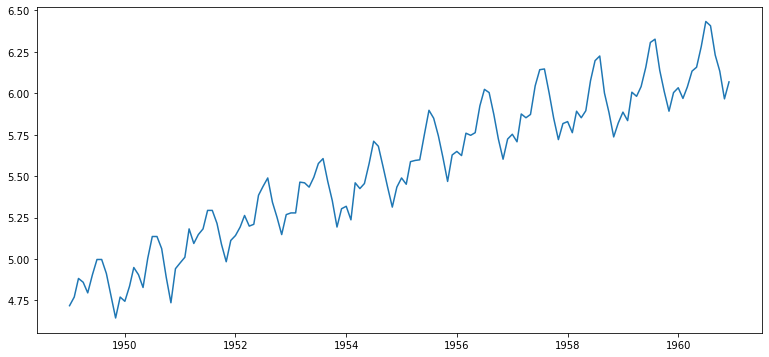

In [18]:
ts_log = np.log(ts2)
plt.plot(ts_log)

In [19]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


#### Moving average 제거 - 추세(Trend) 상쇄하기

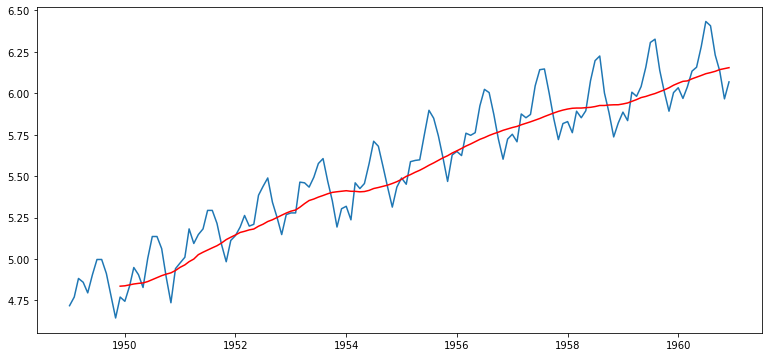

In [20]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [22]:
# window가 12라 이전의 11개의 데이터는 이동평균이 구해지지않아 NaN값이 나옴
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

In [23]:
# 결측치 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

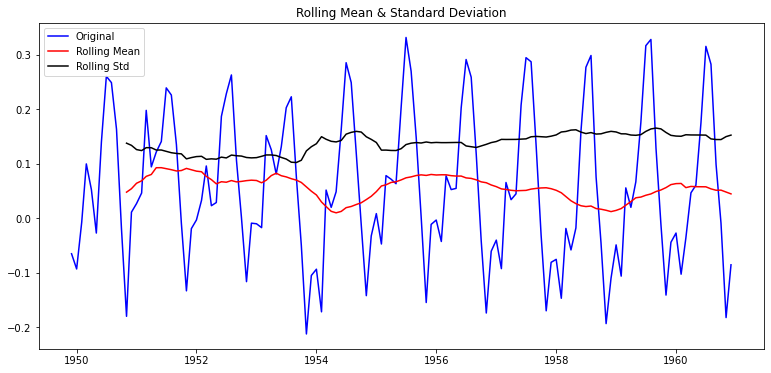

In [24]:
plot_rolling_statistics(ts_log_moving_avg)

In [25]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [26]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)
print('슝=3')

슝=3


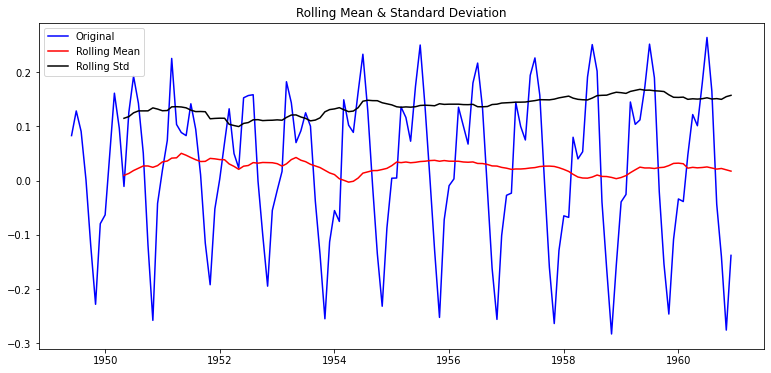

In [27]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [28]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


#### moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다

#### 차분(Differencing) - 계절성(Seasonality) 상쇄하기
- Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화가 있는데 이는 예측에 방해가 되는 불안정성 요소 이것은 Moving Average 제거로는 상쇄되지 않는 효과입니다. 이런 계절적, 주기적 패턴을 계절성(Seasonality)라고 합니다.
- 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법을 차분이라고 하는데 이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 정확히 이번 스텝에서 발생한 변화량을 의미합니다.

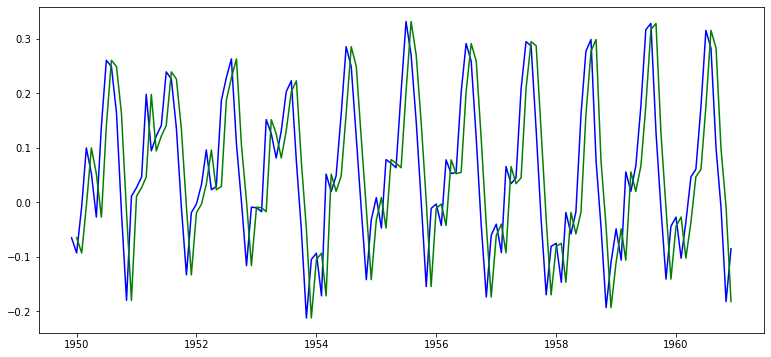

In [29]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

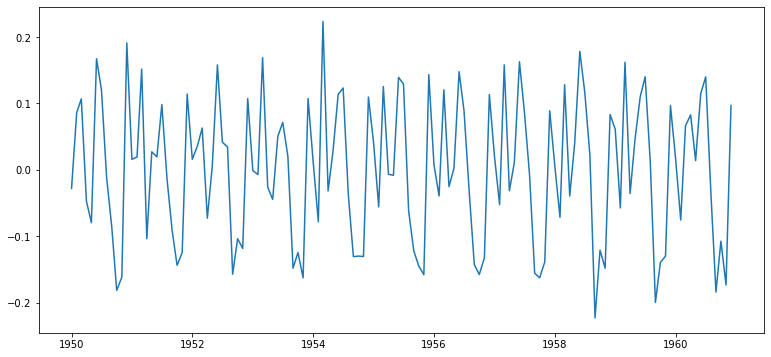

In [30]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

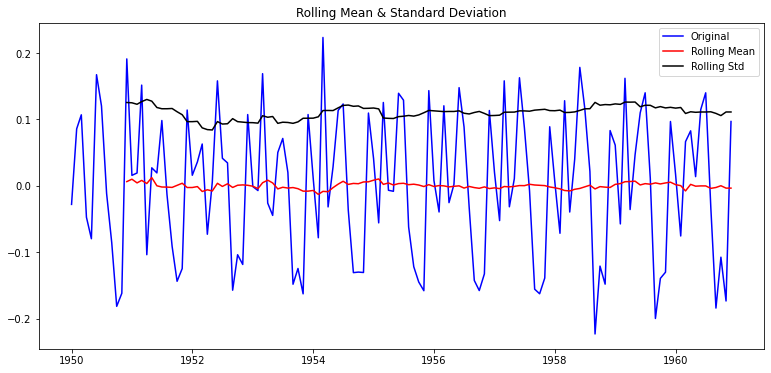

In [31]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [32]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


#### 차분의 결과 더욱더 0에 수렴하는 p-value를 볼 수 있다

### 6. 시계열 분해(Time series decomposition)
- Trend+Seasonality+Residual=Original

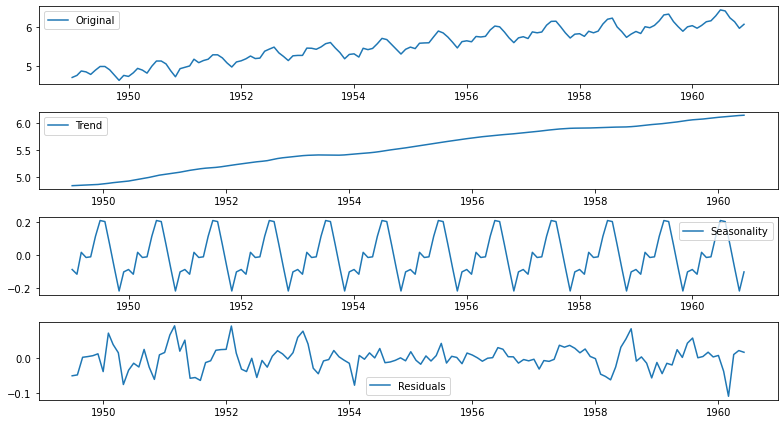

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

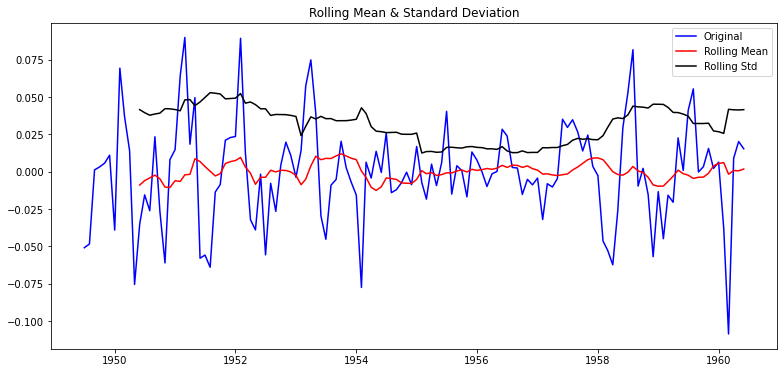

In [34]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [35]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


### 7. ARIMA(Autoregressive Integrated Moving Average) 모델

- AR(자기회귀, Autoregressive)
  - AR은 일반적인 시계열에서 Trend와 Seasonality를 제거한 Residual에 해당하는 부분을 모델링
  - 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점에 해당
- I (차분누적, Integration)
  - I는 일반적인 시계열에서 Seasonality에 해당하는 부분을 모델링
  - 이전 데이터와 d차 차분의 누적(integration) 합이라고 보는 모델
- MA(이동평균, Moving Average)
  - MA는 일반적인 시계열에서 Trend에 해당하는 부분을 모델링
  - 주식값은 항상 최근의 증감 패턴이 지속될 것이라고 예측하는 관점
     
- ARIMA의 파라미터 p,d,q 
  - 자기회귀 모형(AR)의 시차를 의미하는 p, 차분(diffdrence) 횟수를 의미하는 d, 이동평균 모형(MA)의 시차를 의미하는 q
  - p + q < 2, p * q = 0 인 값들을 사용
  - ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)을 통해 결정가능함
  ![pdq](https://aiffelstaticprd.blob.core.windows.net/media/images/E-16-4.max-800x600.png)

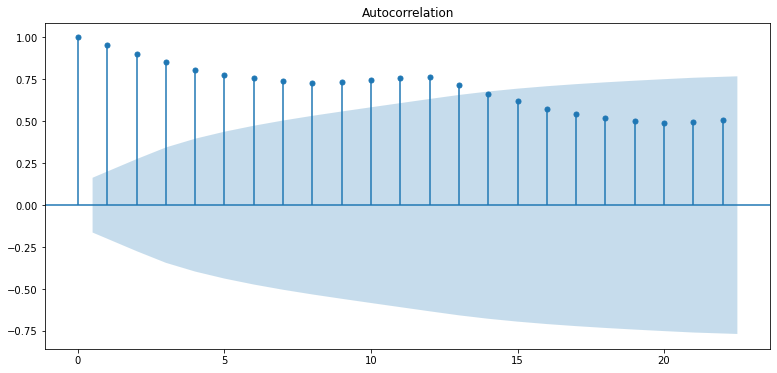

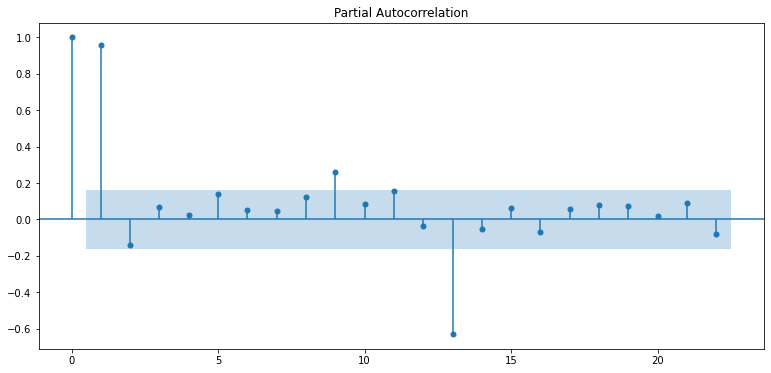

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

#### PACF 그래프를 볼때 p=1이 적합, ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사, 적당한 q값을 찾을수 없어 고려하지않기위해 0 대입

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


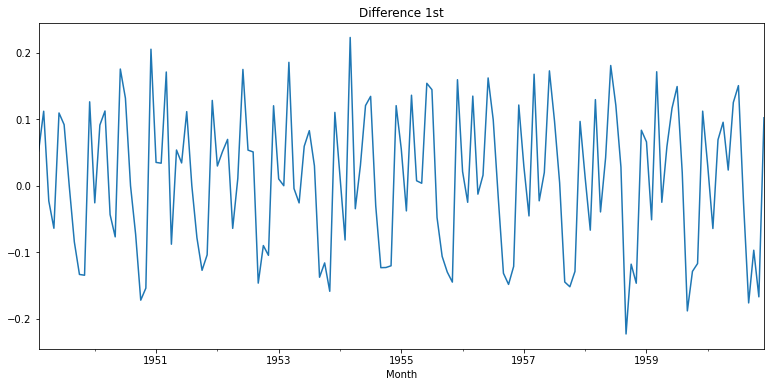

In [37]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


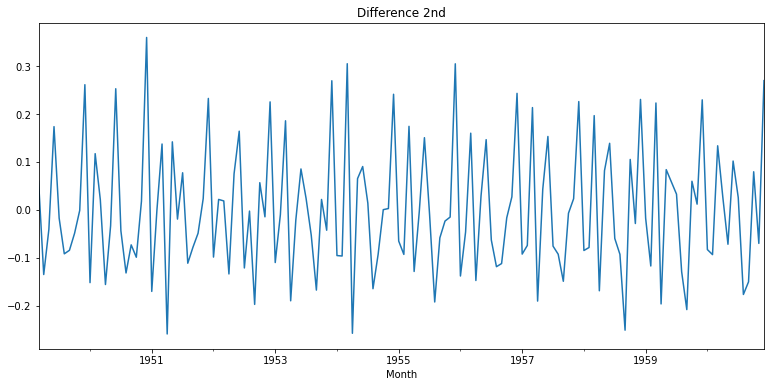

In [38]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### 1차 차분일 때의 p-value가 안정적이므로 d=1이 적당하다

### 8. 학습데이터 분리

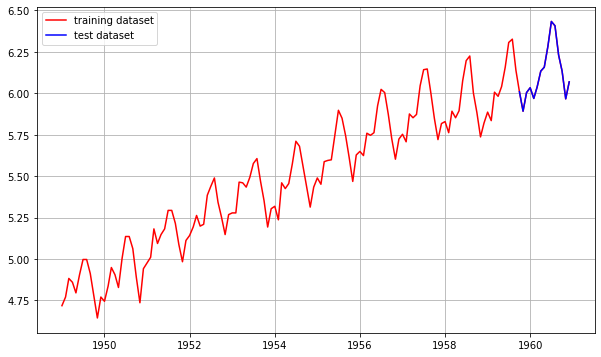

In [39]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [40]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


### 9.  ARIMA 모델 훈련과 추론

In [44]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  128
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 108.023
Method:                       css-mle   S.D. of innovations              0.104
Date:                Tue, 23 Feb 2021   AIC                           -210.046
Time:                        15:56:25   BIC                           -201.490
Sample:                    02-01-1949   HQIC                          -206.570
                         - 09-01-1959                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0108      0.011      0.972      0.331      -0.011       0.033
ar.L1.D.Passengers     0.1754      0.088      1.994      0.046       0.003       0.348
                    

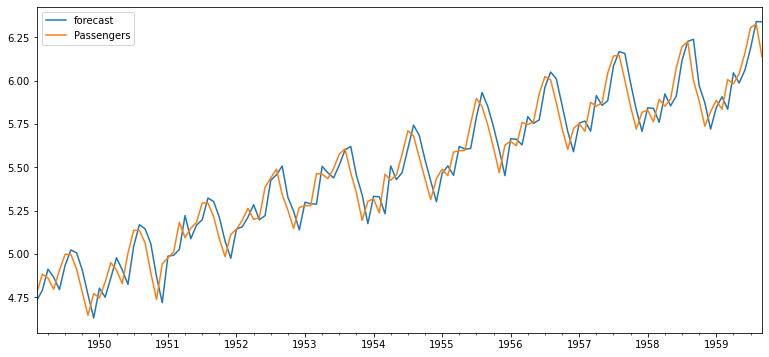

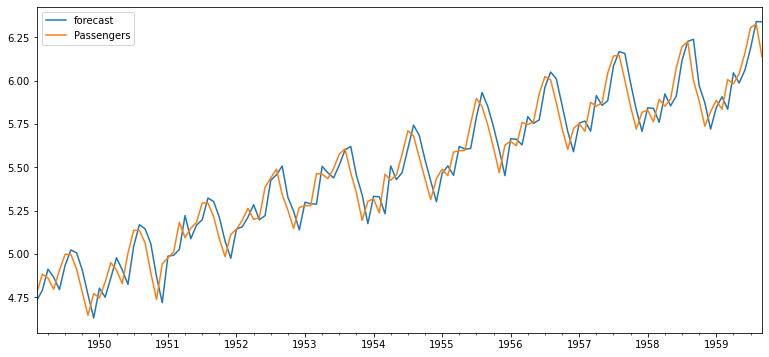

In [45]:
fitted_m.plot_predict()

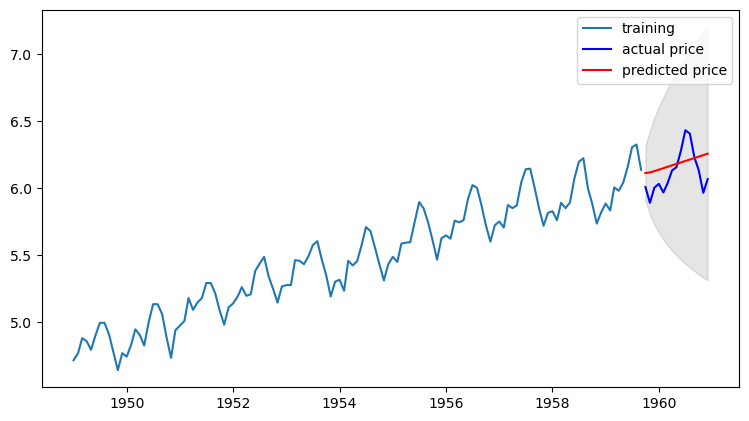

In [46]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [47]:
# 최종 오차율을 계산하기 위해 로그변환되었던 것들을 지수로 돌리는 함수
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5409.550103512347
MAE:  63.136923863759435
RMSE:  73.54964380275644
MAPE: 14.08%


#### 14%의 오차율을 기록하였는데 q값을 변경하여 적절값을 찾을 경우 더 줄어드는 효과를 볼 수 있었다.

### 10. 프로젝트 : 주식 예측

#### 1- 시계열 데이터 준비

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-02-24    56800.0
2020-02-25    57900.0
2020-02-26    56500.0
2020-02-27    55900.0
2020-02-28    54200.0
Name: Close, dtype: float64

#### 2- 전처리

In [177]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  

Series([], Name: Close, dtype: float64)

In [178]:
# 로그 변환
ts_log = np.log(ts)

#### 3- 시계열 안정성 분석

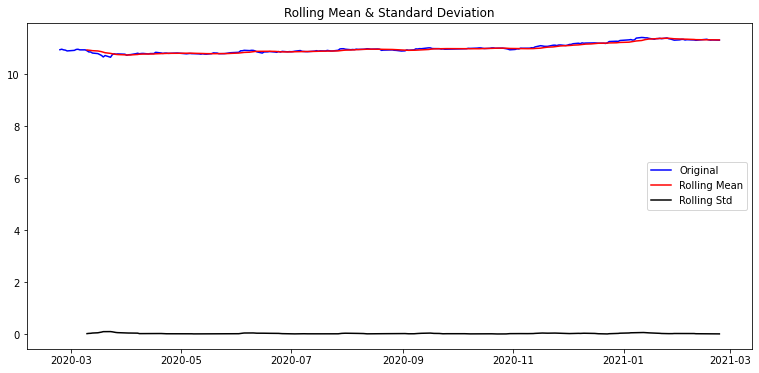

Results of Dickey-Fuller Test:
Test Statistic                  -0.101486
p-value                          0.949290
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


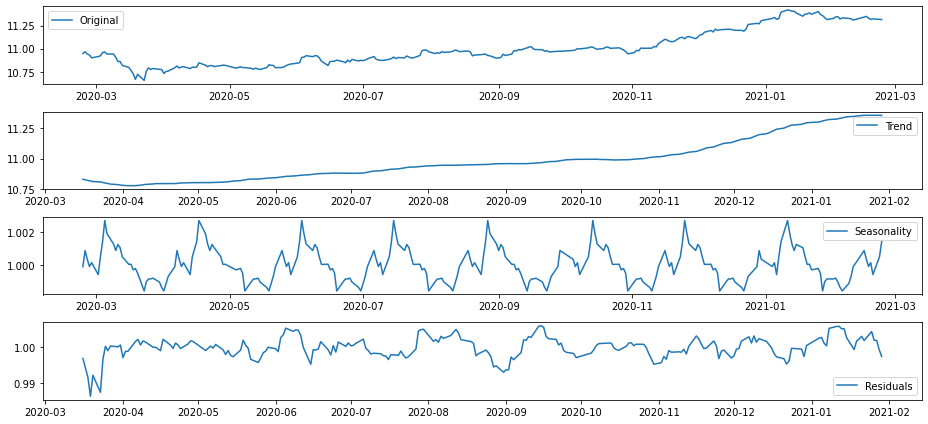

In [179]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [180]:
# 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.901042e+00
p-value                        2.777670e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


#### 4- 학습, 테스트 데이터셋 생성

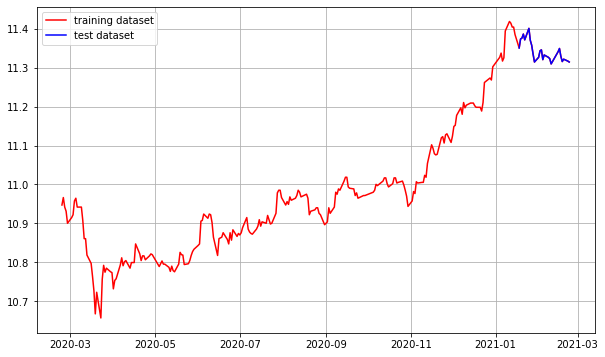

In [181]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### 5- 적정 ARIMA 파라미터 찾기

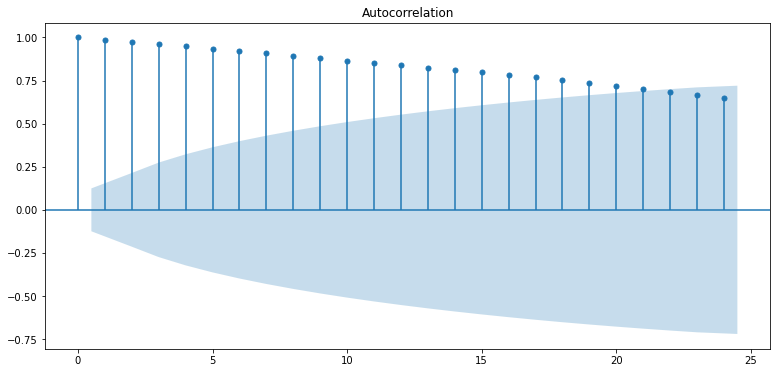

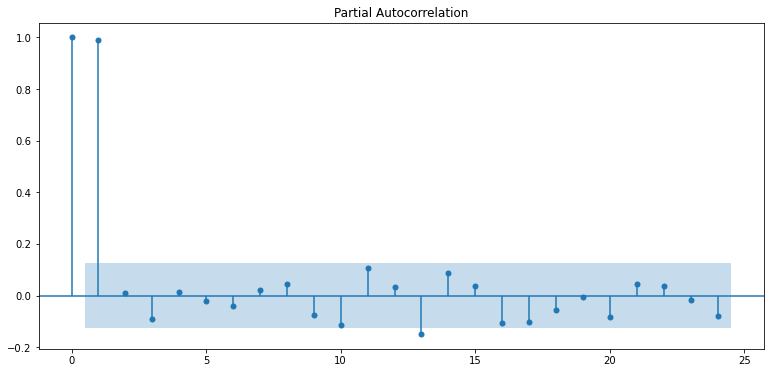

In [182]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.604290e+01
p-value                        5.887423e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.233554e+00
p-value                        1.966048e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.233554e+00
p-value                        1.966048e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+

<AxesSubplot:title={'center':'Difference 4nd'}, xlabel='Date'>

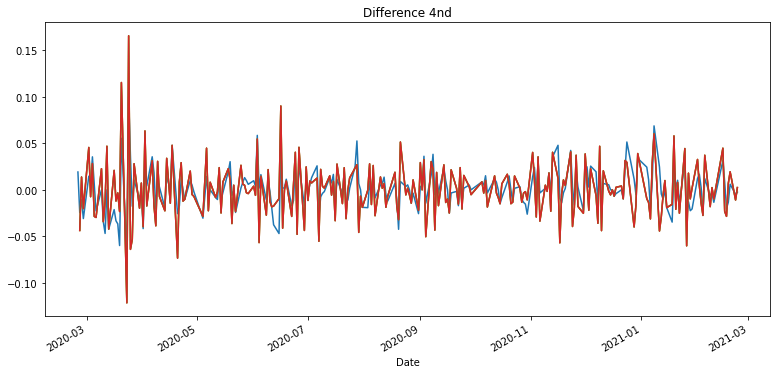

In [184]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

diff_3 = diff_1.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3nd')

augmented_dickey_fuller_test(diff_3)

diff_4 = diff_1.diff(periods=1).iloc[1:]
diff_4.plot(title='Difference 4nd')


#### 6- ARIMA 모델 훈련과 테스트

In [185]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 537.526
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 23 Feb 2021   AIC                          -1069.052
Time:                        17:03:45   BIC                          -1058.844
Sample:                             1   HQIC                         -1064.930
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      1.397      0.162      -0.001       0.005
ar.L1.D.Close    -0.0215      0.067     -0.321      0.748      -0.153       0.110
                                    Root

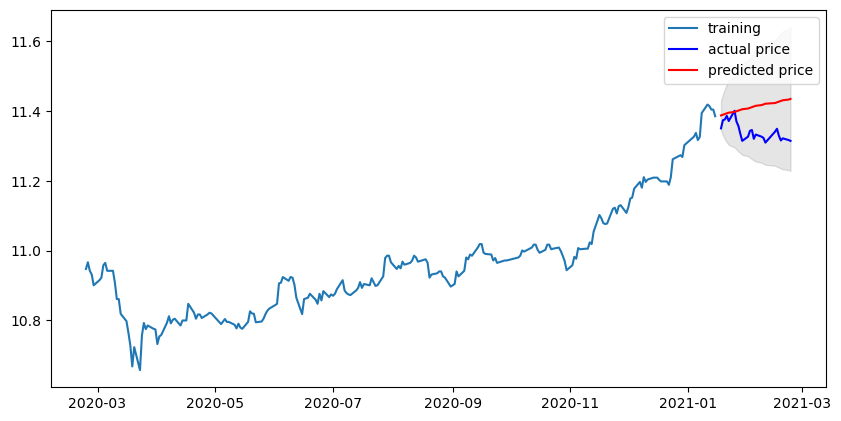

In [186]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [187]:
# 최종 오차율 찾기
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  46389989.18691621
MAE:  6040.034938311393
RMSE:  6811.019687749861
MAPE: 7.26%


### 프로젝트 2 : 비트코인 예측

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/BTC-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64

In [211]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  

Series([], Name: Close, dtype: float64)

In [212]:
# 로그 변환
ts_log = np.log(ts)

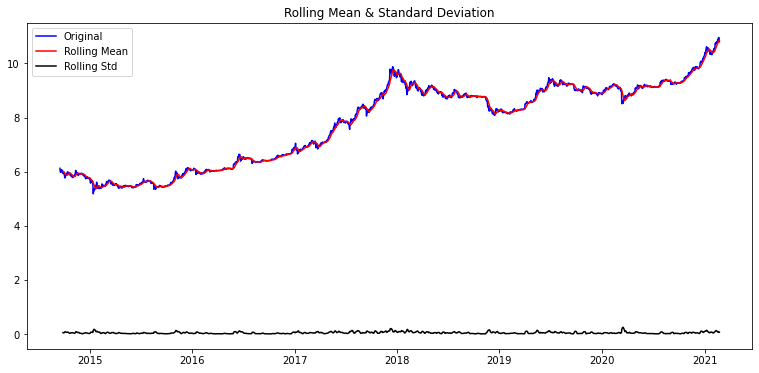

Results of Dickey-Fuller Test:
Test Statistic                    0.287583
p-value                           0.976768
#Lags Used                       10.000000
Number of Observations Used    2341.000000
Critical Value (1%)              -3.433146
Critical Value (5%)              -2.862775
Critical Value (10%)             -2.567428
dtype: float64


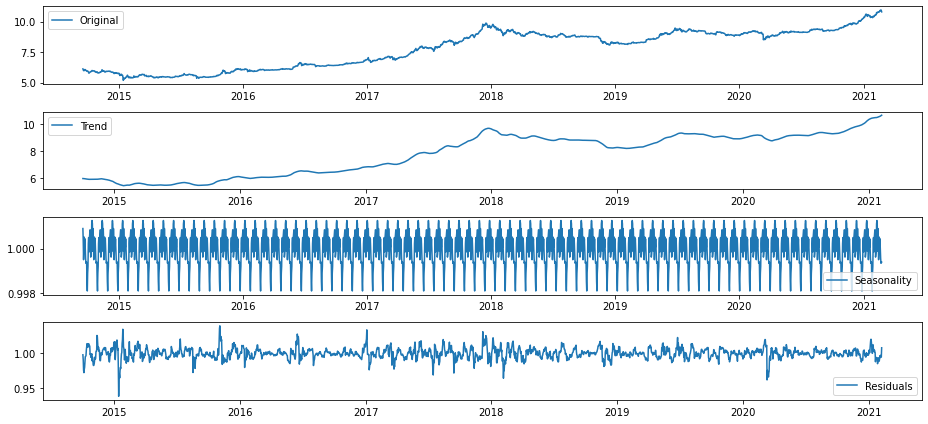

In [213]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [214]:
# 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.269049e+01
p-value                        1.134959e-23
#Lags Used                     2.700000e+01
Number of Observations Used    2.294000e+03
Critical Value (1%)           -3.433204e+00
Critical Value (5%)           -2.862801e+00
Critical Value (10%)          -2.567441e+00
dtype: float64


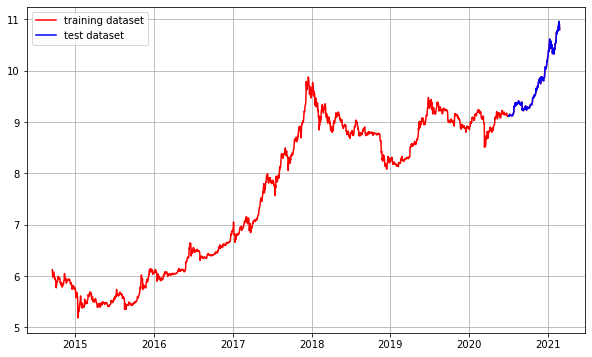

In [215]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

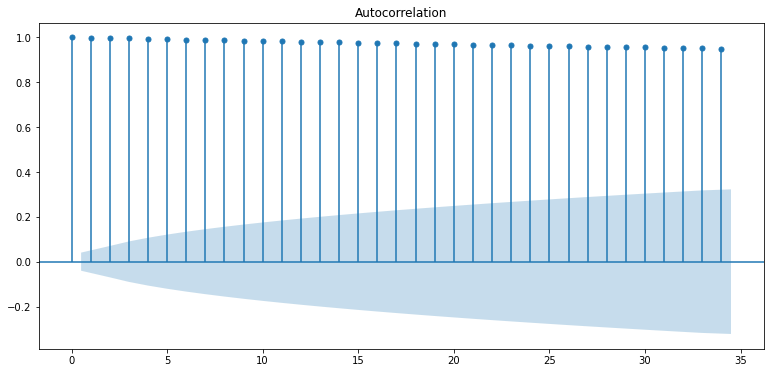

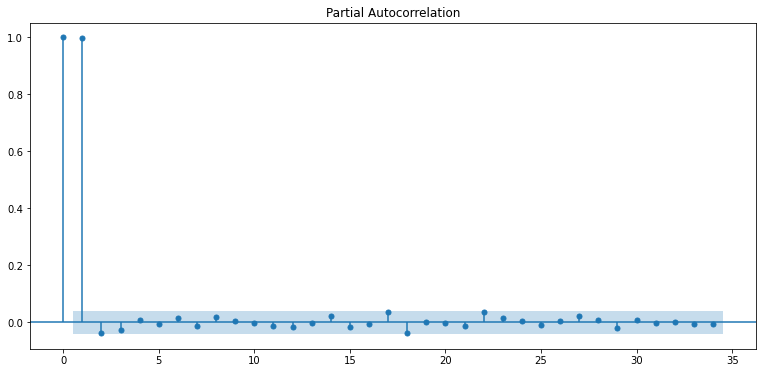

In [216]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.457080e+01
p-value                        4.632067e-27
#Lags Used                     9.000000e+00
Number of Observations Used    2.341000e+03
Critical Value (1%)           -3.433146e+00
Critical Value (5%)           -2.862775e+00
Critical Value (10%)          -2.567428e+00
dtype: float64


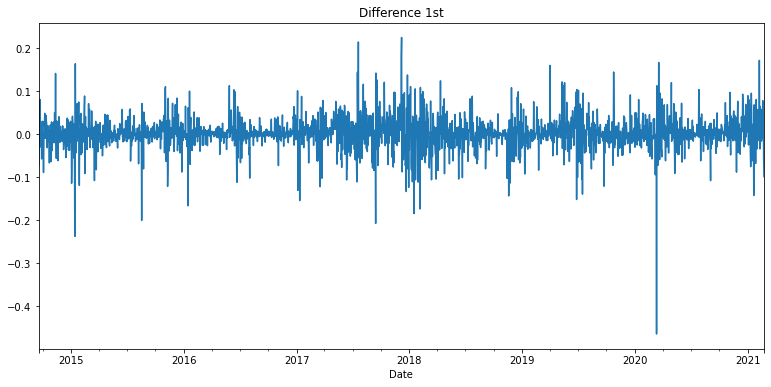

In [217]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


In [231]:
from pmdarima.arima import auto_arima

auto_arima_model = auto_arima(train_data, start_p = 0, start_q=0, trace=True, error_action='ignore', suppress_warnings=True, stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-7652.108, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-7650.709, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-7648.721, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-7647.025, Time=0.23 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=-7645.050, Time=0.85 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=-7643.183, Time=0.65 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=-7650.714, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=-7648.712, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=-7646.763, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=-7644.930, Time=0.54 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=-7643.049, Time=0.73 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=-7648.713, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-7646.720, Time=0.86 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=-7644.825, Time=0.75 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=-7643.395, Time=1.47

In [232]:
from statsmodels.tsa.arima_model import ARIMA


# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2115
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3828.054
Method:                           css   S.D. of innovations              0.040
Date:                Tue, 23 Feb 2021   AIC                          -7652.108
Time:                        17:33:33   BIC                          -7640.794
Sample:                    09-18-2014   HQIC                         -7647.965
                         - 07-02-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.643      0.100      -0.000       0.003


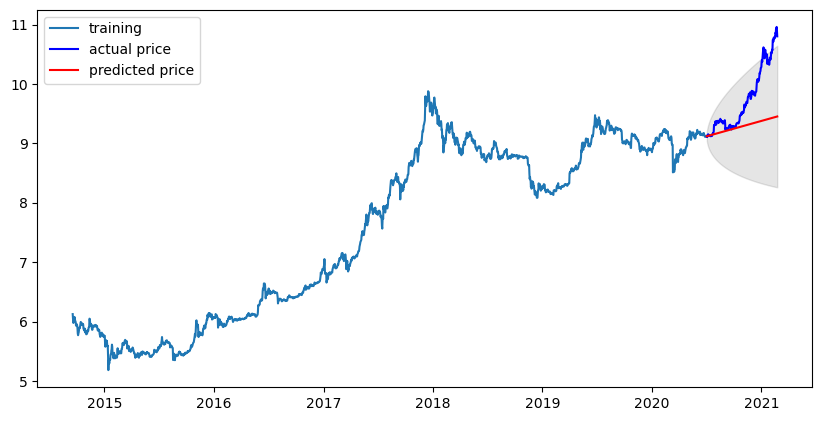

In [233]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [234]:
# 원래값으로 돌리기
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  204107262.5967337
MAE:  8863.615089683206
RMSE:  14286.61130558026
MAPE: 30.38%


### 정리
- 삼성전자 데이터의 경우 기간이 길 수록 log scale이 커져서 조금만 차이나도 error가 엄청 차이나서 정확도가 낮게 나오는 현상이 발견되었다
- 비트코인의 경우 수동으로 파라미터 값을 찾아본 결과와 auto로 찾아본 결과의 최적치를 씀에도 30%이하로 내려가지 않았다.
  내 생각에는 데이터의 유동성이 너무 큰 그래프라 그런게 아닐까 추측해보았다.